# LUAD U2AF1 S34F + KRAS G12 immune state

## Background:
- U2AF1 S34F mutations are recurrent and cause transcriptome-wide pre-mRNA splicing alterations
- U2AF1 S34F mutations co-occur with KRAS
- eVIP2 results suggest KRAS G12 functional impact is different in U2AF1 S34F background
- This code is adapted from Dr. Alexis Thornton (althornt@ucsc.edu)

![alt text](u2af1-kras-inputs/eVIP2_results.png "Title")

- **Is there a difference in immune cell composition of tumors with U2AF1 mutation (+/- KRAS mutation)?**

## Data from:

- The Immune Landscape of Cancer by Thorsson et al. [link](https://www.sciencedirect.com/science/article/pii/S1074761318301213?via%3Dihub)

- TCGA CIBERSORT results [link](https://gdc.cancer.gov/about-data/publications/panimmune)


# Data import and processing

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.stats import kruskal
import scikit_posthocs as sp
from statsmodels.sandbox.stats.multicomp import multipletests
from matplotlib.patches import Patch
from scipy.stats import chi2_contingency
import lifelines
import matplotlib
# import rpy2.robjects.numpy2ri
# from rpy2.robjects.packages import importr
# rpy2.robjects.numpy2ri.activate()

import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams['pdf.fonttype'] = 42

In [2]:
#import TCGA mutation data and  TCGA cibersort results 
mut_status  =  pd.read_csv("mutations-3.txt",sep="\t",index_col=1)
tcga_cib = pd.read_csv("TCGA.Kallisto.fullIDs.cibersort.relative.tsv",sep="\t",index_col=0)
tcga_cib.index =  [i[:-13].replace(".","-") for i in tcga_cib.index]

#keep only LUAD tumor samples [end  in 01 - 09], drop normals and controls
keep = [i for i in tcga_cib.index.tolist() if int(i[-2:]) <10 ]      
tcga_cib  = tcga_cib[tcga_cib.index.isin(keep)]
tcga_cib =  tcga_cib.loc[(tcga_cib["CancerType"] ==  "LUAD") & (tcga_cib["P.value"] <  0.05) ]
tcga_cib.head()

,CancerType,B.cells.naive,B.cells.memory,Plasma.cells,T.cells.CD8,T.cells.CD4.naive,T.cells.CD4.memory.resting,T.cells.CD4.memory.activated,T.cells.follicular.helper,T.cells.regulatory..Tregs.,...,Macrophages.M2,Dendritic.cells.resting,Dendritic.cells.activated,Mast.cells.resting,Mast.cells.activated,Eosinophils,Neutrophils,P.value,Correlation,RMSE
TCGA-L9-A444-01,LUAD,0.081641,0.000000,0.106933,0.200429,0.0,0.115956,0.031438,0.107587,0.011264,...,0.160298,0.000387,0.000000,0.020057,0.000000,0.0,0.000000,0.012,0.251370,0.989856
TCGA-MP-A4T9-01,LUAD,0.124235,0.000000,0.040309,0.131143,0.0,0.017014,0.000000,0.064633,0.018790,...,0.280186,0.000763,0.014585,0.105868,0.000000,0.0,0.007987,0.008,0.288700,0.962539
TCGA-MP-A4TC-01,LUAD,0.073753,0.000000,0.036225,0.089593,0.0,0.131089,0.019192,0.022293,0.042744,...,0.321196,0.000856,0.000000,0.000000,0.072435,0.0,0.008784,0.044,0.158150,1.020573
TCGA-MP-A4TA-01,LUAD,0.006148,0.004224,0.100610,0.164437,0.0,0.163522,0.000000,0.114429,0.000000,...,0.203849,0.000000,0.045830,0.004307,0.000000,0.0,0.000000,0.030,0.182755,1.016587
TCGA-L4-A4E5-01,LUAD,0.012174,0.016290,0.103330,0.153432,0.0,0.164744,0.004025,0.070815,0.037547,...,0.204045,0.046069,0.001131,0.031567,0.000000,0.0,0.003654,0.022,0.201387,1.002993


In [3]:
pnotsig =  tcga_cib.loc[(tcga_cib["P.value"] >  0.05) ]
pnotsig

,CancerType,B.cells.naive,B.cells.memory,Plasma.cells,T.cells.CD8,T.cells.CD4.naive,T.cells.CD4.memory.resting,T.cells.CD4.memory.activated,T.cells.follicular.helper,T.cells.regulatory..Tregs.,...,Macrophages.M2,Dendritic.cells.resting,Dendritic.cells.activated,Mast.cells.resting,Mast.cells.activated,Eosinophils,Neutrophils,P.value,Correlation,RMSE


In [4]:
#group samples by KRAS and U2AF1 mutation status
U2AF1_WT_KRAS_WT = mut_status[(mut_status["U2AF1"]=="WT")
        & (mut_status["KRAS"]=="WT")].index.tolist()
U2AF1_WT_KRAS_G12 = mut_status[(mut_status["U2AF1"]=="WT")
        & (mut_status["KRAS"].str.startswith("G12"))].index.tolist()
U2AF1_S34F_KRAS_WT = mut_status[(mut_status["U2AF1"]=="S34F")
        & (mut_status["KRAS"]=="WT")].index.tolist()
U2AF1_S34F_KRAS_G12 = mut_status[(mut_status["U2AF1"]=="S34F")
        & (mut_status["KRAS"].str.startswith("G12"))].index.tolist()

#check theres no overlap in the lists
d = [U2AF1_WT_KRAS_WT,U2AF1_WT_KRAS_G12,U2AF1_S34F_KRAS_WT,U2AF1_S34F_KRAS_G12]
result = set(d[0]).intersection(*d[1:])
# print(result)

#Add labels to categories 
tcga_cib.loc[tcga_cib.index.isin(U2AF1_WT_KRAS_WT), 'label'] = "U2AF1_WT_KRAS_WT"
tcga_cib.loc[tcga_cib.index.isin(U2AF1_WT_KRAS_G12), 'label'] = "U2AF1_WT_KRAS_G12"
tcga_cib.loc[tcga_cib.index.isin(U2AF1_S34F_KRAS_WT), 'label'] = "U2AF1_S34F_KRAS_WT"
tcga_cib.loc[tcga_cib.index.isin(U2AF1_S34F_KRAS_G12), 'label'] = "U2AF1_S34F_KRAS_G12"

In [5]:
#import supplemental file with Leukocyte fraction and immune subtypes 
supp_df = pd.read_excel("1-s2.0-S1074761318301213-mmc2.xlsx",index_col=0)
supp_df = supp_df[supp_df["TCGA Study"] ==  "LUAD"]

#add mut status label 
tcga_cib_id = tcga_cib["label"]
tcga_cib_id.index =  [i[:-3] for i in tcga_cib.index] #need to make id's match
supp_df = pd.merge(tcga_cib_id, supp_df, left_index=True, right_index=True)
supp_df.tail()

,label,TCGA Study,Immune Subtype,TCGA Subtype,Leukocyte Fraction,Stromal Fraction,Intratumor Heterogeneity,TIL Regional Fraction,Proliferation,Wound Healing,...,T Cells CD8,T Cells Follicular Helper,T Cells gamma delta,T Cells Regulatory Tregs,Lymphocytes,Neutrophils.1,Eosinophils.1,Mast Cells,Dendritic Cells,Macrophages
TCGA-NJ-A55O,U2AF1_WT_KRAS_G12,LUAD,C3,NaN,0.279332,NaN,NaN,2.126038,-0.5683,-0.1575,...,0.072306,0.034603,0.0,0.008338,0.452121,0.003325,0.0,0.039345,0.024793,0.480416
TCGA-NJ-A55R,U2AF1_WT_KRAS_G12,LUAD,C3,NaN,0.345369,0.77,0.32,4.936996,-0.2662,-0.0930,...,0.043850,0.089178,0.0,0.019092,0.601283,0.000000,0.0,0.065746,0.000860,0.332111
TCGA-NJ-A7XG,U2AF1_WT_KRAS_WT,LUAD,C3,NaN,0.122267,0.38,0.46,NaN,-1.2904,-0.2265,...,0.029149,0.057171,0.0,0.025752,0.534062,0.000819,0.0,0.156920,0.078543,0.229655
TCGA-O1-A52J,U2AF1_WT_KRAS_WT,LUAD,C3,NaN,0.283192,0.50,0.17,6.113616,-0.8886,-0.2175,...,0.039354,0.020347,0.0,0.029580,0.216966,0.000000,0.0,0.089617,0.055289,0.638128
TCGA-S2-AA1A,U2AF1_WT_KRAS_WT,LUAD,C3,NaN,0.419555,0.68,0.20,4.335710,-1.2086,-0.2790,...,0.070130,0.042888,0.0,0.060451,0.680990,0.000000,0.0,0.083623,0.016527,0.218860


In [6]:
print("Number of U2AF1_WT_KRAS_WT samples:",(tcga_cib["label"]=="U2AF1_WT_KRAS_WT").sum())
print("Number of U2AF1_WT_KRAS_G12 samples:",(tcga_cib["label"]=="U2AF1_WT_KRAS_G12").sum())
print("Number of U2AF1_S34F_KRAS_WT samples:",(tcga_cib["label"]=="U2AF1_S34F_KRAS_WT").sum())
print("Number of U2AF1_S34F_KRAS_G12 samples:",(tcga_cib["label"]=="U2AF1_S34F_KRAS_G12").sum())
print("Number of other samples:",(tcga_cib["label"].isna()).sum())

Number of U2AF1_WT_KRAS_WT samples: 286
Number of U2AF1_WT_KRAS_G12 samples: 106
Number of U2AF1_S34F_KRAS_WT samples: 5
Number of U2AF1_S34F_KRAS_G12 samples: 4
Number of other samples: 19


### Immune subtypes distribution & Chi-square , Fishers test

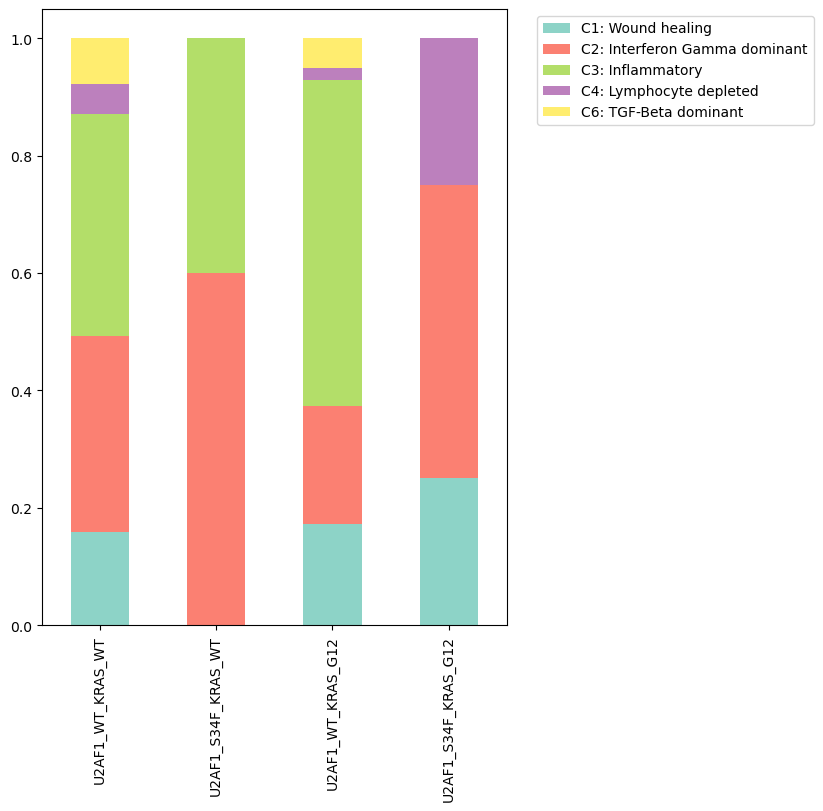

In [9]:
#plot immune subtype  
supp_df  = supp_df[supp_df['Immune Subtype'].notna()]

#calculate proportion each subtype within each group (subtype/all with mut status label)
ag = supp_df.groupby(["Immune Subtype","label"])["label"].count()/supp_df.groupby(["label"])["label"].count()

#setting custom order 
df = ag.unstack()
df.columns  = pd.CategoricalIndex(df.columns.values, 
                                 ordered=True, 
                                 categories=["U2AF1_WT_KRAS_WT", "U2AF1_S34F_KRAS_WT", "U2AF1_WT_KRAS_G12",
                                             "U2AF1_S34F_KRAS_G12"])
df = df.sort_index(axis=1).T
df.plot(kind='bar',figsize=(6,8),legend=True,sort_columns=True, stacked=True,cmap="Set3");

#customize legend
plt.legend(["C1: Wound healing",
            "C2: Interferon Gamma dominant",
            "C3: Inflammatory",
            "C4: Lymphocyte depleted",
            "C6: TGF-Beta dominant"],bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.savefig("immune_subtypes.png", bbox_inches='tight',dpi=300)

In [10]:
supp_df

,label,TCGA Study,Immune Subtype,TCGA Subtype,Leukocyte Fraction,Stromal Fraction,Intratumor Heterogeneity,TIL Regional Fraction,Proliferation,Wound Healing,...,T Cells CD8,T Cells Follicular Helper,T Cells gamma delta,T Cells Regulatory Tregs,Lymphocytes,Neutrophils.1,Eosinophils.1,Mast Cells,Dendritic Cells,Macrophages
TCGA-05-4384,U2AF1_WT_KRAS_WT,LUAD,C3,LUAD.1,0.199447,0.51,0.02,0.000000,-1.2215,-0.2755,...,0.067195,0.055868,0.0,0.011322,0.443620,0.016567,0.0,0.030681,0.003356,0.505775
TCGA-05-4398,U2AF1_WT_KRAS_WT,LUAD,C2,LUAD.3,0.286318,0.67,0.25,7.390615,0.3394,0.1785,...,0.082546,0.073496,0.0,0.009748,0.418660,0.007006,0.0,0.064015,0.036953,0.473366
TCGA-05-4402,U2AF1_WT_KRAS_WT,LUAD,C2,LUAD.2,0.285064,0.56,0.55,0.868542,-0.0694,0.0185,...,0.055048,0.021450,0.0,0.024925,0.378799,0.009205,0.0,0.106345,0.044217,0.461434
TCGA-05-4403,U2AF1_WT_KRAS_G12,LUAD,C6,LUAD.4,0.255516,0.54,0.01,0.405006,-0.8043,-0.0680,...,0.030266,0.019345,0.0,0.034306,0.392376,0.004997,0.0,0.047762,0.003348,0.551517
TCGA-05-4405,U2AF1_WT_KRAS_G12,LUAD,C3,LUAD.3,0.304389,0.62,0.49,0.144852,-0.6193,-0.1750,...,0.111413,0.035440,0.0,0.019045,0.546041,0.000000,0.0,0.037400,0.008184,0.408375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-NJ-A55O,U2AF1_WT_KRAS_G12,LUAD,C3,NaN,0.279332,NaN,NaN,2.126038,-0.5683,-0.1575,...,0.072306,0.034603,0.0,0.008338,0.452121,0.003325,0.0,0.039345,0.024793,0.480416
TCGA-NJ-A55R,U2AF1_WT_KRAS_G12,LUAD,C3,NaN,0.345369,0.77,0.32,4.936996,-0.2662,-0.0930,...,0.043850,0.089178,0.0,0.019092,0.601283,0.000000,0.0,0.065746,0.000860,0.332111
TCGA-NJ-A7XG,U2AF1_WT_KRAS_WT,LUAD,C3,NaN,0.122267,0.38,0.46,NaN,-1.2904,-0.2265,...,0.029149,0.057171,0.0,0.025752,0.534062,0.000819,0.0,0.156920,0.078543,0.229655
TCGA-O1-A52J,U2AF1_WT_KRAS_WT,LUAD,C3,NaN,0.283192,0.50,0.17,6.113616,-0.8886,-0.2175,...,0.039354,0.020347,0.0,0.029580,0.216966,0.000000,0.0,0.089617,0.055289,0.638128


In [11]:
#contingency table for Chi2 and Fishers test
c_table  = supp_df.groupby(["Immune Subtype","label"])["label"].count().unstack().fillna(0)
c_table

label,U2AF1_S34F_KRAS_G12,U2AF1_S34F_KRAS_WT,U2AF1_WT_KRAS_G12,U2AF1_WT_KRAS_WT
Immune Subtype,,,,
C1,1.0,0.0,17.0,41.0
C2,2.0,3.0,20.0,86.0
C3,0.0,2.0,55.0,98.0
C4,1.0,0.0,2.0,13.0
C6,0.0,0.0,5.0,20.0


In [12]:
#chi-square  
chi2, pval, dof, ex = chi2_contingency(c_table)
print('chi2= %.4f, p-value= %.4f, dof= %.4f'% (chi2 ,pval, dof))

chi2= 21.1151, p-value= 0.0487, dof= 12.0000


## Leukocyte fraction and CIBERSORT estimates

Multiplying Leukocyte Fraction by cibersort relative fractions to estimate overall fraction of each cell in the tissue

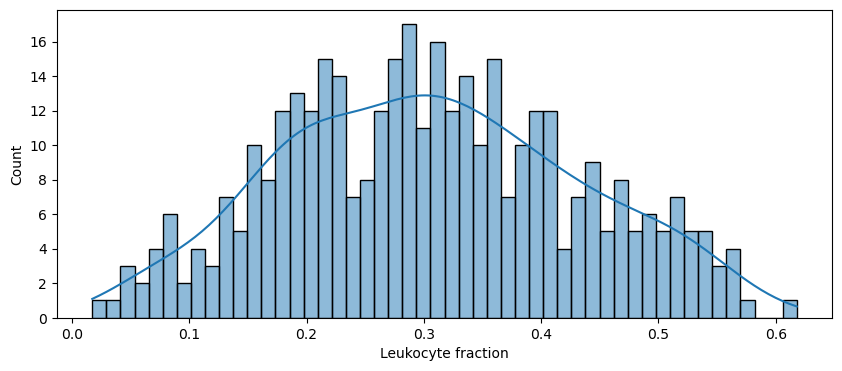

In [13]:
#LF distribution across all samples
plt.figure(figsize=(10,4))
sns.histplot(supp_df["Leukocyte Fraction"],bins=50,kde=True)
plt.xlabel("Leukocyte fraction");

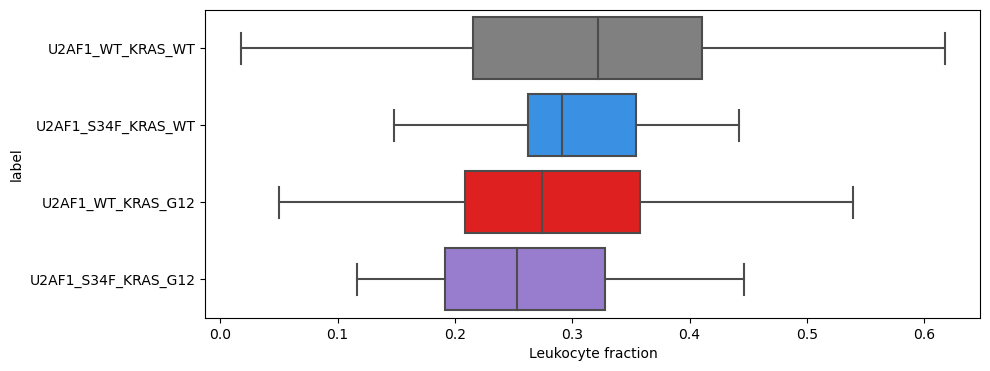

In [14]:
plt.figure(figsize=(10,4))

my_pal = {'U2AF1_WT_KRAS_WT': "gray", 'U2AF1_S34F_KRAS_WT':'dodgerblue', 
          'U2AF1_WT_KRAS_G12': "r", 'U2AF1_S34F_KRAS_G12':'mediumpurple'}

sns.boxplot(data=supp_df.sort_values(by="label",ascending=False), 
            x="Leukocyte Fraction",y="label",palette=my_pal,fliersize=0, 
            order = ["U2AF1_WT_KRAS_WT", "U2AF1_S34F_KRAS_WT", "U2AF1_WT_KRAS_G12",
                                             "U2AF1_S34F_KRAS_G12"])



# sns.stripplot(data=supp_df.sort_values(by="label",ascending=False), 
#             x="Leukocyte Fraction",y="label", marker="D", 
#             alpha=0.25, s=12,color="black");

plt.xlabel("Leukocyte fraction");

In [14]:
#count N for each mutation category to see if each group has at least n = 5 (min for KW test)
leukocounts_df = supp_df.loc[:, supp_df.columns.isin(['Leukocyte Fraction', 'label'])]
# leukocounts_df

LEUKOFRACDICT = {}

LEUKOFRACDICT['wtkraswt'] = len(leukocounts_df.loc[(leukocounts_df['label'] == "U2AF1_WT_KRAS_WT")])
LEUKOFRACDICT['s34fkraswt'] = len(leukocounts_df.loc[(leukocounts_df['label'] == "U2AF1_S34F_KRAS_WT")])
LEUKOFRACDICT['wtkrasg12'] = len(leukocounts_df.loc[(leukocounts_df['label'] == "U2AF1_WT_KRAS_G12")])
LEUKOFRACDICT['s34fkrasg12'] = len(leukocounts_df.loc[(leukocounts_df['label'] == "U2AF1_S34F_KRAS_G12")])

LEUKOFRACDICT

# zeroh_df = working_df.loc[(working_df['Compound']=='0h')]

#compare against # samples from Alexis's starting df, before merging with leukocyte fractions

#Alexis's #s
# Number of U2AF1_WT_KRAS_WT samples: 367
# Number of U2AF1_WT_KRAS_G12 samples: 135
# Number of U2AF1_S34F_KRAS_WT samples: 6
# Number of U2AF1_S34F_KRAS_G12 samples: 6
# Number of other samples: 28

#my #s
#     {'wtkraswt': 319, 's34fkraswt': 6, 'wtkrasg12': 126, 's34fkrasg12': 6}

#conclusion: All categories have N > 5 so KW test can be done. 
#However, we lost some wtkraswt and s34fkraswt samples after merging with leukocyte fraction
#maybe because not all aptients had lekuocyte fraction data

{'wtkraswt': 258, 's34fkraswt': 5, 'wtkrasg12': 99, 's34fkrasg12': 4}

In [15]:
#perform KW + posthoc on leukocyte fraction 


df = sp.posthoc_dunn(supp_df.dropna(), val_col="Leukocyte Fraction",
                group_col='label', p_adjust = 'bonferroni',sort=True)
df

#conclusion: only U2AF1 WT KRAS WT and U2AF1 WT KRAS G12 patient samples have 
#significantly different leukocyte fractions 
#Try fisher's exact test + posthocs next?

,U2AF1_S34F_KRAS_G12,U2AF1_S34F_KRAS_WT,U2AF1_WT_KRAS_G12,U2AF1_WT_KRAS_WT
U2AF1_S34F_KRAS_G12,1.0,1.0,1.000000,1.000000
U2AF1_S34F_KRAS_WT,1.0,1.0,1.000000,1.000000
U2AF1_WT_KRAS_G12,1.0,1.0,1.000000,0.113153
U2AF1_WT_KRAS_WT,1.0,1.0,0.113153,1.000000


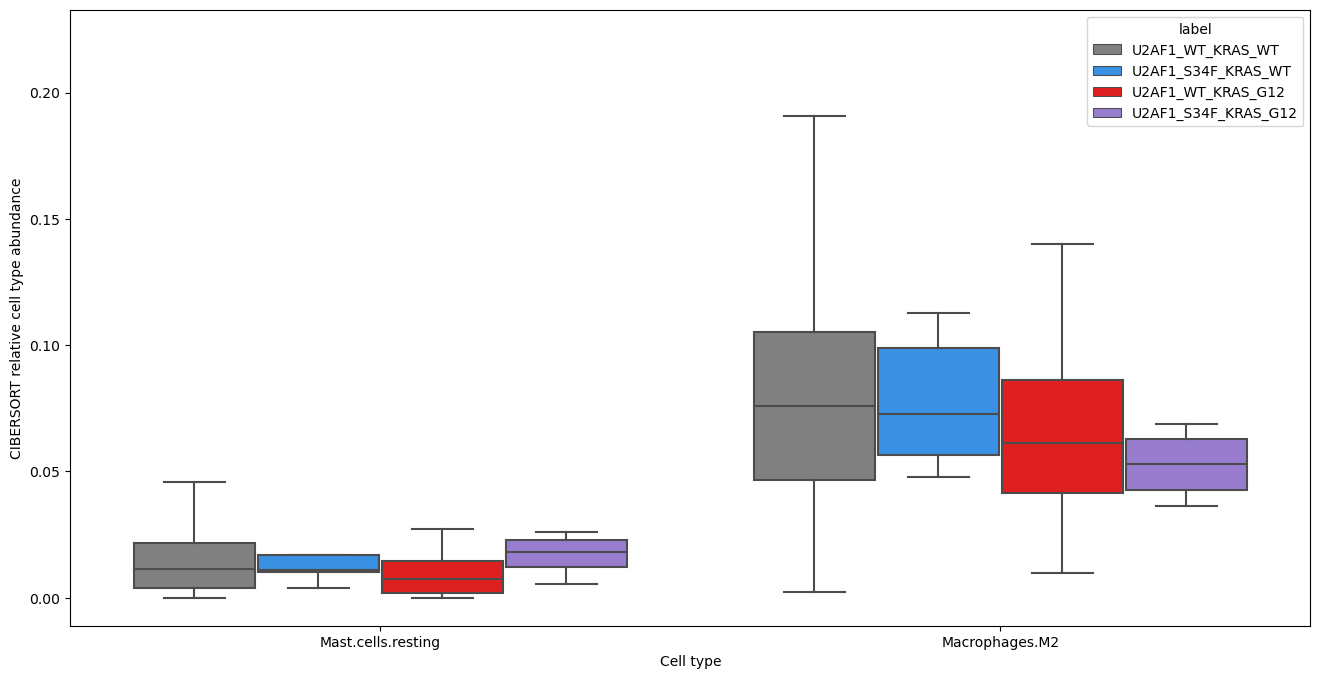

In [10]:
#multiply LF by cibersort relative fractions to estimate overall fracaton of cell in tissue
cell_types = tcga_cib.drop(columns=["CancerType","P.value","Correlation","RMSE","label"]).columns.tolist()
tcga_cib_data = tcga_cib.drop(columns=["CancerType","P.value","Correlation","RMSE","label"])
tcga_cib_data.index =  [i[:-3] for i in tcga_cib_data.index] #need to make id's match

#add LF to cibersort df 
tcga_cib_lf = pd.merge(tcga_cib_data, supp_df["Leukocyte Fraction"], left_index=True, right_index=True).drop_duplicates()

#multiply
tcga_cib_relative = tcga_cib_lf[cell_types].multiply(tcga_cib_lf["Leukocyte Fraction"], axis="index")

#add back in label
tcga_cib_relative = pd.merge(tcga_cib_relative, tcga_cib["label"], left_index=True, right_index=True)

#melt ...
tcga_cib_relative_long = pd.melt(tcga_cib_relative, "label").sort_values(by='label',ascending=False)
# print(tcga_cib_relative_long.head())

#only plot cell type for mast cells resting, dendritic cells resting, macrophages m2
tcga_cib_sig = tcga_cib_relative_long.loc[(tcga_cib_relative_long['variable'] == 'Mast.cells.resting')
                                         | (tcga_cib_relative_long['variable'] == 'Macrophages.M2')]

plt.figure(figsize=(16,8))

my_pal = {'U2AF1_WT_KRAS_WT': "gray", 'U2AF1_S34F_KRAS_WT':'dodgerblue',
          'U2AF1_WT_KRAS_G12': "r", 'U2AF1_S34F_KRAS_G12':'mediumpurple'}

hue_order = ['U2AF1_WT_KRAS_WT', 'U2AF1_S34F_KRAS_WT', 'U2AF1_WT_KRAS_G12', 'U2AF1_S34F_KRAS_G12']
ax=sns.boxplot(data=tcga_cib_sig, x="variable", y="value", hue='label', hue_order=hue_order, 
               palette=my_pal, fliersize=0)

plt.xticks(rotation=0)
plt.xlabel("Cell type")
plt.ylabel("CIBERSORT relative cell type abundance")
plt.savefig("cibersort_immunesubtype.pdf", format='pdf', transparent=True)
# plt.savefig("u2af1-kras-outputs/cibersort_lf_relative.png", bbox_inches='tight',dpi=300)

In [18]:
#Kruskal Wallis - are median of all groups in cell type equal?

pval_df_rel = pd.DataFrame(index = cell_types, columns=["kruskal_pval"] )

for cell in cell_types:
    #get lists of values
    cell_df  = tcga_cib_relative_long[tcga_cib_relative_long["variable"] == cell]
    cell_df_l =  cell_df.groupby('label')["value"].apply(list).reset_index(name='new')
    cell_df_groups = cell_df_l["new"].tolist()
        
    # compare samples
    stat, p = kruskal(*cell_df_groups,nan_policy="omit")
    pval_df_rel.loc[cell,"kruskal_pval"] = p

#BH adjust
p_adjusted = multipletests(pval_df_rel["kruskal_pval"].values, method='fdr_bh')

pval_df_rel["kruskal_pval_bh_adj"]=p_adjusted[1]
pval_df_rel.sort_values(by="kruskal_pval_bh_adj").head()

,kruskal_pval,kruskal_pval_bh_adj
Mast.cells.resting,0.003641,0.080106
Macrophages.M2,0.014972,0.164693
B.cells.memory,0.044698,0.311727
Dendritic.cells.resting,0.056678,0.311727
T.cells.CD4.memory.resting,0.17924,0.657214


In [18]:
tcga_cib_relative_long

,label,variable,value
0,U2AF1_WT_KRAS_WT,B.cells.naive,0.016113
5577,U2AF1_WT_KRAS_WT,Macrophages.M0,0.008532
5592,U2AF1_WT_KRAS_WT,Macrophages.M0,0.015251
5591,U2AF1_WT_KRAS_WT,Macrophages.M0,0.021951
5590,U2AF1_WT_KRAS_WT,Macrophages.M0,0.000000
...,...,...,...
8931,NaN,Neutrophils,0.006934
8989,NaN,Neutrophils,0.000000
9007,NaN,Neutrophils,0.000000
9039,NaN,Neutrophils,0.001470


In [19]:
tcga_cib_relative

,B.cells.naive,B.cells.memory,Plasma.cells,T.cells.CD8,T.cells.CD4.naive,T.cells.CD4.memory.resting,T.cells.CD4.memory.activated,T.cells.follicular.helper,T.cells.regulatory..Tregs.,T.cells.gamma.delta,...,Macrophages.M0,Macrophages.M1,Macrophages.M2,Dendritic.cells.resting,Dendritic.cells.activated,Mast.cells.resting,Mast.cells.activated,Eosinophils,Neutrophils,label
TCGA-05-4384,0.016113,0.000000,0.017083,0.013402,0.0,0.015983,0.000000,0.011143,0.002258,0.0,...,0.000000,0.002066,0.088801,0.000000,0.000669,0.006119,0.000000,0.0,0.003304,U2AF1_WT_KRAS_WT
TCGA-05-4398,0.017537,0.000000,0.033086,0.023634,0.0,0.017846,0.002571,0.021043,0.002791,0.0,...,0.000000,0.020311,0.096713,0.010580,0.000000,0.000000,0.018329,0.0,0.002006,U2AF1_WT_KRAS_WT
TCGA-05-4402,0.013577,0.000000,0.019314,0.015692,0.0,0.036020,0.000000,0.006115,0.007105,0.0,...,0.008513,0.009765,0.107026,0.004192,0.008413,0.030315,0.000000,0.0,0.002624,U2AF1_WT_KRAS_WT
TCGA-05-4403,0.027657,0.000000,0.022733,0.007733,0.0,0.024201,0.000000,0.004943,0.008766,0.0,...,0.026388,0.009921,0.096851,0.000855,0.000000,0.012204,0.000000,0.0,0.001277,U2AF1_WT_KRAS_G12
TCGA-05-4405,0.033278,0.000000,0.053673,0.033913,0.0,0.027916,0.000000,0.010788,0.005797,0.0,...,0.033905,0.000000,0.087667,0.000000,0.002491,0.011384,0.000000,0.0,0.000000,U2AF1_WT_KRAS_G12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-NJ-A55O,0.036937,0.000000,0.012946,0.020197,0.0,0.044216,0.000000,0.009666,0.002329,0.0,...,0.000000,0.002468,0.126727,0.000000,0.006925,0.010990,0.000000,0.0,0.000929,U2AF1_WT_KRAS_G12
TCGA-NJ-A55R,0.000000,0.069344,0.066944,0.015144,0.0,0.018618,0.000000,0.030799,0.006594,0.0,...,0.056279,0.004457,0.053965,0.000000,0.000297,0.022707,0.000000,0.0,0.000000,U2AF1_WT_KRAS_G12
TCGA-NJ-A7XG,0.000000,0.005655,0.012236,0.003564,0.0,0.022951,0.000000,0.006990,0.003149,0.0,...,0.000000,0.001265,0.025649,0.003437,0.006167,0.019186,0.000000,0.0,0.000100,U2AF1_WT_KRAS_WT
TCGA-O1-A52J,0.001906,0.000000,0.000000,0.011145,0.0,0.026118,0.000000,0.005762,0.008377,0.0,...,0.003023,0.000000,0.116469,0.002768,0.012889,0.025379,0.000000,0.0,0.000000,U2AF1_WT_KRAS_WT


In [20]:
#Do KW posthocs for mast cells resting
df = sp.posthoc_dunn(tcga_cib_relative.dropna(), val_col="Mast.cells.resting",
                group_col='label', p_adjust = 'bonferroni',sort=True)
df

#conclusion: U2AF1_WT_KRAS_G12 and U2AF1_WT_KRAS_WT mast cells resting are differet p = 0.002405

,U2AF1_S34F_KRAS_G12,U2AF1_S34F_KRAS_WT,U2AF1_WT_KRAS_G12,U2AF1_WT_KRAS_WT
U2AF1_S34F_KRAS_G12,1.000000,1.0,0.894812,1.000000
U2AF1_S34F_KRAS_WT,1.000000,1.0,1.000000,1.000000
U2AF1_WT_KRAS_G12,0.894812,1.0,1.000000,0.002405
U2AF1_WT_KRAS_WT,1.000000,1.0,0.002405,1.000000


In [21]:
#Do KW posthocs for dendritic cells resting
df = sp.posthoc_dunn(tcga_cib_relative.dropna(), val_col="Dendritic.cells.resting",
                group_col='label', p_adjust = 'bonferroni',sort=True)
df

#conclusion: dendritic cells resting are not different

,U2AF1_S34F_KRAS_G12,U2AF1_S34F_KRAS_WT,U2AF1_WT_KRAS_G12,U2AF1_WT_KRAS_WT
U2AF1_S34F_KRAS_G12,1.000000,1.000000,0.405005,0.894391
U2AF1_S34F_KRAS_WT,1.000000,1.000000,0.491119,1.000000
U2AF1_WT_KRAS_G12,0.405005,0.491119,1.000000,0.459117
U2AF1_WT_KRAS_WT,0.894391,1.000000,0.459117,1.000000


In [22]:
#Do KW posthocs for macrophages M2
df = sp.posthoc_dunn(tcga_cib_relative.dropna(), val_col="Macrophages.M2",
                group_col='label', p_adjust = 'bonferroni',sort=True)
df

#conclusion: Macrophages.M2 are different for U2AF1 WT KRAS WT vs U2AF1 WT KRAS G12 p = 0.017900

,U2AF1_S34F_KRAS_G12,U2AF1_S34F_KRAS_WT,U2AF1_WT_KRAS_G12,U2AF1_WT_KRAS_WT
U2AF1_S34F_KRAS_G12,1.000000,1.0,1.0000,0.942993
U2AF1_S34F_KRAS_WT,1.000000,1.0,1.0000,1.000000
U2AF1_WT_KRAS_G12,1.000000,1.0,1.0000,0.017900
U2AF1_WT_KRAS_WT,0.942993,1.0,0.0179,1.000000


# Other immune scores from Thorsson et al. supplemental file

In [24]:
# Kruskal Wallis - are median of all groups in cell type equal?
supp_df_long = pd.melt(supp_df.drop(columns=["TCGA Study","Immune Subtype","TCGA Subtype"]), "label").sort_values(by='variable')

#make empty df
pval_df = pd.DataFrame(index = supp_df_long.columns, columns=["kruskal_pval"] )

for cell in supp_df.columns:
    #get lists of values
    cell_df  = supp_df_long[supp_df_long["variable"] == cell]
    if not cell_df.empty:
        cell_df_l =  cell_df.groupby('label')["value"].apply(list).reset_index(name='new')
        cell_df_groups = cell_df_l["new"].tolist()
        # compare samples
        stat, p = kruskal(*cell_df_groups,nan_policy="omit")
        pval_df.loc[cell,"kruskal_pval"] = p
            
#BH adjust p-values
p_adjusted = multipletests(pval_df["kruskal_pval"].values, method='fdr_bh')

pval_df["kruskal_pval_bh_adj"]=p_adjusted[1]
pval_df.sort_values(by="kruskal_pval_bh_adj").head()

,kruskal_pval,kruskal_pval_bh_adj
TCR Evenness,0.008313,0.174567
Number of Segments,0.005569,0.174567
PFI Time,0.011586,0.182481
OS Time,0.018649,0.214494
Mast Cells,0.023523,0.214494


In [26]:
supp_df

,label,TCGA Study,Immune Subtype,TCGA Subtype,Leukocyte Fraction,Stromal Fraction,Intratumor Heterogeneity,TIL Regional Fraction,Proliferation,Wound Healing,...,T Cells CD8,T Cells Follicular Helper,T Cells gamma delta,T Cells Regulatory Tregs,Lymphocytes,Neutrophils.1,Eosinophils.1,Mast Cells,Dendritic Cells,Macrophages
TCGA-05-4244,U2AF1_WT_KRAS_G12,LUAD,C4,NaN,0.246926,0.56,0.25,3.025515,0.1289,0.0590,...,0.045560,0.062374,0.0,0.006690,0.319964,0.000000,0.0,0.037055,0.054944,0.588037
TCGA-05-4249,U2AF1_WT_KRAS_G12,LUAD,C3,LUAD.5,0.251681,0.51,0.26,2.151890,-0.8788,-0.1325,...,0.030955,0.031014,0.0,0.031006,0.291149,0.011298,0.0,0.144820,0.215617,0.337117
TCGA-05-4382,U2AF1_WT_KRAS_WT,LUAD,C6,LUAD.6,0.460245,0.79,0.50,5.399126,-0.1487,-0.0135,...,0.058022,0.028702,0.0,0.014831,0.336943,0.000000,0.0,0.043183,0.003205,0.616669
TCGA-05-4384,U2AF1_WT_KRAS_WT,LUAD,C3,LUAD.1,0.199447,0.51,0.02,0.000000,-1.2215,-0.2755,...,0.067195,0.055868,0.0,0.011322,0.443620,0.016567,0.0,0.030681,0.003356,0.505775
TCGA-05-4389,U2AF1_WT_KRAS_WT,LUAD,C2,LUAD.2,0.336176,0.52,0.50,NaN,0.2406,0.1405,...,0.168626,0.056618,0.0,0.043894,0.475052,0.006767,0.0,0.119110,0.067985,0.331086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-NJ-A55O,U2AF1_WT_KRAS_G12,LUAD,C3,NaN,0.279332,NaN,NaN,2.126038,-0.5683,-0.1575,...,0.072306,0.034603,0.0,0.008338,0.452121,0.003325,0.0,0.039345,0.024793,0.480416
TCGA-NJ-A55R,U2AF1_WT_KRAS_G12,LUAD,C3,NaN,0.345369,0.77,0.32,4.936996,-0.2662,-0.0930,...,0.043850,0.089178,0.0,0.019092,0.601283,0.000000,0.0,0.065746,0.000860,0.332111
TCGA-NJ-A7XG,U2AF1_WT_KRAS_WT,LUAD,C3,NaN,0.122267,0.38,0.46,NaN,-1.2904,-0.2265,...,0.029149,0.057171,0.0,0.025752,0.534062,0.000819,0.0,0.156920,0.078543,0.229655
TCGA-O1-A52J,U2AF1_WT_KRAS_WT,LUAD,C3,NaN,0.283192,0.50,0.17,6.113616,-0.8886,-0.2175,...,0.039354,0.020347,0.0,0.029580,0.216966,0.000000,0.0,0.089617,0.055289,0.638128


In [25]:
#posthoc KW test for supplememntal file cell types -- Th17

df = sp.posthoc_dunn(supp_df.dropna(), val_col="Th17 Cells",
                group_col='label', p_adjust = 'bonferroni',sort=True)
df

#conclusion: U2AF1_WT_KRAS_G12 and U2AF1_WT_KRAS_WT dendritic cells resting are differet p = 0.032002

,U2AF1_S34F_KRAS_G12,U2AF1_S34F_KRAS_WT,U2AF1_WT_KRAS_G12,U2AF1_WT_KRAS_WT
U2AF1_S34F_KRAS_G12,1.0,1.0,1.000000,1.000000
U2AF1_S34F_KRAS_WT,1.0,1.0,1.000000,1.000000
U2AF1_WT_KRAS_G12,1.0,1.0,1.000000,0.402868
U2AF1_WT_KRAS_WT,1.0,1.0,0.402868,1.000000


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


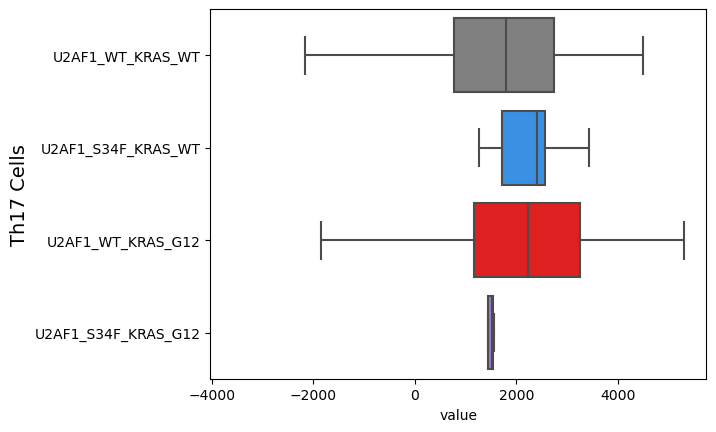

In [26]:
#plotting each numerical variable from supplement file

for var in ["Th17 Cells"]:
# for var in supp_df_long.variable.unique():
    df= supp_df_long[supp_df_long["variable"]==var]
    fig = plt.figure()

    sns.boxplot(data=df.sort_values(by="label",ascending=False), 
                x="value",y="label", palette = my_pal, 
                order = ['U2AF1_WT_KRAS_WT', 'U2AF1_S34F_KRAS_WT', 'U2AF1_WT_KRAS_G12', 'U2AF1_S34F_KRAS_G12'], 
                fliersize=0)

    plt.ylabel(var, fontsize=14)
    plt.legend().remove()

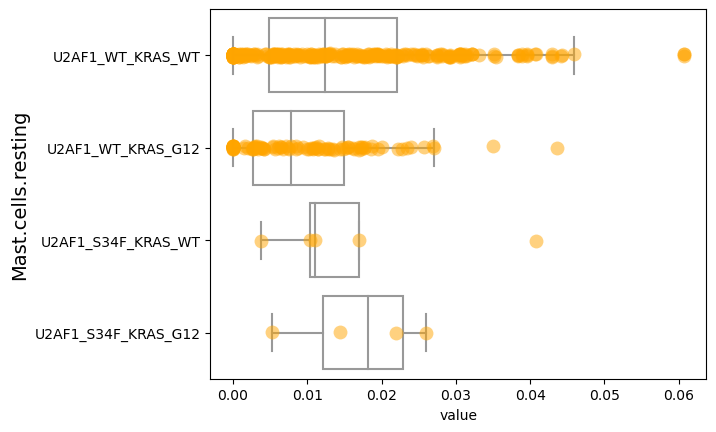

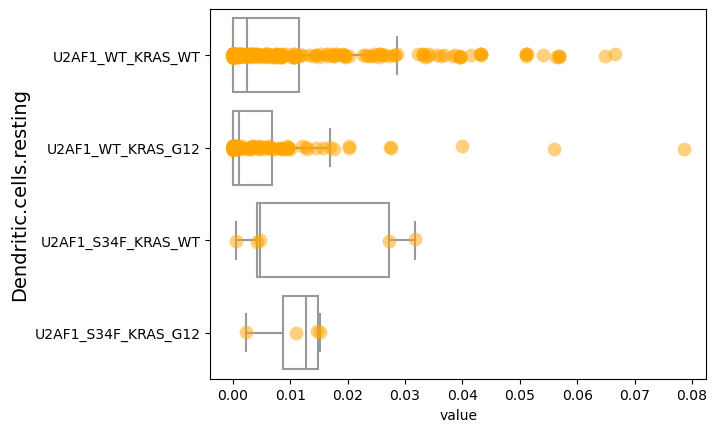

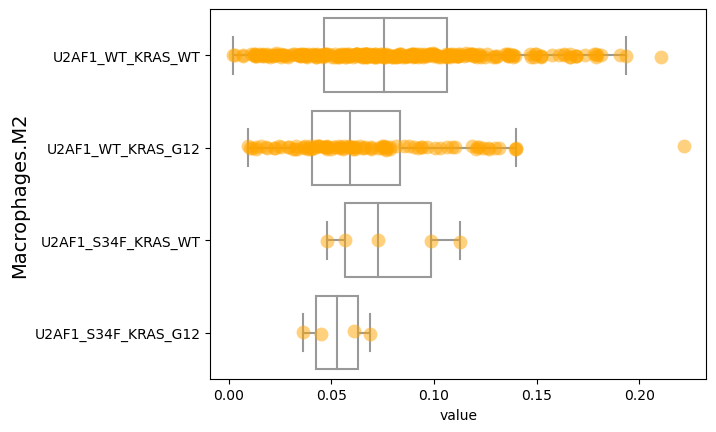

In [28]:

# tcga_cib_relative_long = pd.melt(tcga_cib_relative, "label").sort_values(by='label',ascending=False)

# print(tcga_cib_relative_long)

#plotting each numerical variable from cibersort file
# for var in tcga_cib_relative_long.variable.unique():
for var in ["Mast.cells.resting","Dendritic.cells.resting","Macrophages.M2"]:
    
    
    df= tcga_cib_relative_long[tcga_cib_relative_long["variable"]==var]
    fig = plt.figure()

    sns.boxplot(data=df.sort_values(by="label",ascending=False), 
                x="value",y="label",color="white",fliersize=0);

    sns.stripplot(data=df.sort_values(by="label",ascending=False), 
                x="value",y="label", 
                alpha=0.5, s=10, color="orange", jitter=.02);
    plt.ylabel(var, fontsize=14)
#     plt.show()
    
#     plt.savefig("u2af1-kras-outputs/"+var+".png", bbox_inches='tight',dpi=300)
    plt.clf